<center>
<h1>Programming Exercise 3:<br>Multi-class Classification and Neural Networks<br></h1>
<h2>Machine Learning<br></h2>
</center>

# Introduction

In this exercise, you will implement one-vs-all logistic regression and neural
networks to recognize hand-written digits. Before starting the programming
exercise, we strongly recommend watching the video lectures and completing
the review questions for the associated topics.

In [14]:
# Library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io

%matplotlib inline

In [15]:
# Submission

import mlcourse.submission
submit = mlcourse.submission.create_submission('ex3')

login_email = 'example@example.com'
submission_token = 'SUBMISSIONTOKEN'

In [16]:
# Helper functions

def display_data(X):
    """
    Displays 2D data stored in X in a nice grid.
    """
    
    padding = 1
    
    m, n = X.shape
    
    plot_width = int(np.ceil(np.sqrt(m)))
    data_width = int(np.ceil(np.sqrt(n)))
    
    grid_size = plot_width*data_width + (plot_width+1)*padding
    image_grid = np.zeros((grid_size, grid_size)) - 0.2
    
    assert data_width*data_width == n, "Data images must be square!"
    
    im_counter = 0
    
    for rw in range(plot_width):
        for cl in range(plot_width):
            if im_counter == m:
                break
            else:
                loc_x = padding + (data_width + padding)*rw
                loc_y = padding + (data_width + padding)*cl
                image_grid[loc_x:loc_x+data_width, loc_y:loc_y+data_width] = \
                    X[im_counter].reshape((data_width, data_width))
                im_counter += 1
    
    plt.imshow(image_grid.T, cmap='gray')   
    plt.axis('off')

# Multi-class Classification

For this exercise, you will use logistic regression and neural networks to
recognize handwritten digits (from 0 to 9). Automated handwritten digit
recognition is widely used today - from recognizing zip codes (postal codes)
on mail envelopes to recognizing amounts written on bank checks. This
exercise will show you how the methods you've learned can be used for this
classification task.

In the first part of the exercise, you will extend your previous implemention
of logistic regression and apply it to one-vs-all classification.

## Dataset

You are given a data set in `./data/ex3/ex3data1.mat` that contains 5000 training examples
of handwritten digits[^1]. The `.mat` format means that that the data has
been saved in a native Octave/MATLAB matrix format, instead of a text
(ASCII) format like a csv-file. These matrices can be read directly into your
program by using the `scipy.io.loadmat()` method. After loading, matrices of the correct
dimensions and values will appear in your program in a dictionary.
The keys for this dictionary contain the variable names for the matrices and you should
assign them to variables.

```python
    # Load Training Data
    print('Loading and Visualizing Data ...\n')
    data = scipy.io.loadmat('./data/ex3/ex3data1.mat')

    # Assign names to the matrices in the dictionary.
    X = data['X']
    y = data['y']
```

There are 5000 training examples in `ex3data1.mat`, where each training
example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is
represented by a floating point number indicating the grayscale intensity at
that location. The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional
vector. Each of these training examples becomes a single row in our data
matrix $X$. This gives us a 5000 by 400 matrix `X` where every row is a training
example for a handwritten digit image.

$$
X =
\left[\begin{matrix}- (x^{(1)})^T - \\- (x^{(2)})^T - \\\vdots\\- (x^{(m)})^T - \end{matrix}\right]
$$

The second part of the training set is a 5000-dimensional vector `y` that
contains labels for the training set. The orignal version of this exercise
was based on Octave/MATLAB and used the label "10" to reprsent the digit zero.
Since indexing in Python starts from zero (as opposed to one in Octave/MATLAB)
we change all the "10" labels back to "0" by performing a simple search and
replace on the array `y`.

```python
    y[np.where(y==10)[0]] = 0
```

## Visualizing the data

You will begin by visualizing a subset of the training set. In next cell,
the code randomly selects selects 100 rows from `X` and passes those rows
to the `display_data()` function. This function maps each row to a 20 pixel by
20 pixel grayscale image and displays the images together. We have provided
the `display_data` function (at the top of this notebook right after the imports),
and you are encouraged to examine the code to see how it works. After you run this
step, you should see an image like Figure 1.

<center>
<img src="./figs/ex3_fig1.png">
Figure 1: Examples from the data set.
</center>

Loading and Visualizing Data...



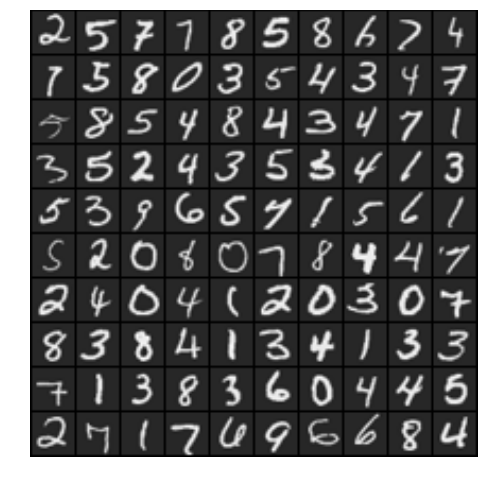

In [19]:
## Setup the parameters you will use for this part of the exercise

# 20x20 Input Images of Digits
input_layer_size  = 400

# 10 labels, from 0 to 9
num_labels = 10;          
                          
## Loading and Visualizing Data
#  We start the exercise by first loading and visualizing the dataset. 
#  You will be working with a dataset that contains handwritten digits.

# Load Training Data
print('Loading and Visualizing Data...\n')
data = scipy.io.loadmat('./data/ex3/ex3data1.mat')

# training data stored in arrays X, y
X = data['X']
y = data['y']

# The `.m` file used the label '10' for '0'; change that back.
# (we don't care about MATLAB compatibility anymore. ha!)
y[np.where(y==10)[0]] = 0

m = X.shape[0]

# Randomly select 100 data points to display
rand_indices = np.random.permutation(m)
sel = X[rand_indices[:100], :]

plt.figure(figsize=(8, 8))
display_data(sel)
# plt.savefig('./figs/ex3_fig1.png')

## Vectorizing Logistic Regression

You will be using multiple one-vs-all logistic regression models to build a
multi-class classifier. Since there are 10 classes, you will need to train 10
separate logistic regression classifiers. To make this training efficient, it is
important to ensure that your code is well vectorized. In this section, you
will implement a vectorized version of logistic regression that does not employ
any for loops. You can use your code in the last exercise as a starting point
for this exercise.

We will begin by writing a vectorized version of the cost function. Recall
that in (unregularized) logistic regression, the cost function is

$$J(\theta) = \dfrac{1}{m} \sum_{i = 1}^{m} \left[-y^{(i)}\log{(h_\theta(x^{(i)}))} -(1-y^{(i)})\log{(1- h_\theta(x^{(i)}))} \right],$$

To compute each element in the summation, we have to compute $h_\theta(x^{(i)})$ for 
every example $i$, where $h_\theta(x^{(i)}) = g(\theta^Tx^{(i)})$ and
$g(z) = \dfrac{1}{1 + e^{-z}}$ is the sigmoid function. It turns out that we can
compute this quickly for all our examples by using matrix multiplication.
Let us define $X$ and $\theta$ as

$$
X =
\left[\begin{matrix} - (x^{(1)})^T - \\- (x^{(2)})^T - \\\vdots\\- (x^{(m)})^T - \end{matrix}\right]
\quad
\text{ and }
\quad
\theta = 
\left[\begin{matrix}\theta_0\\\theta_1\\\vdots\\\theta_n\end{matrix}\right]
$$

Then, by computing the matrix product $X\theta$, we have

$$
X =
\left[\begin{matrix} - (x^{(1)})^T\theta - \\- (x^{(2)})^T\theta - \\\vdots\\- (x^{(m)})^T\theta - \end{matrix}\right] = 
\left[\begin{matrix} - \theta^T(x^{(1)}) - \\- \theta^T(x^{(2)}) - \\\vdots\\- \theta^T(x^{(m)}) - \end{matrix}\right]
$$

In the last equality, we used the fact that $a^Tb = b^Ta$ is $a$ and $b$ are vectors.
This allows us to compute the products $\theta^Tx^{(i)}$ for all our examples $i$ in one
line of code.

Your job is to write the unregularized cost function in the function `lr_cost_function()`
Your implementation should use the strategy we presented above to calculate $\theta^Tx^{(i)}$.
You should also use a vectorized approach for the rest of the
cost function. A fully vectorized version of `lr_cost_function()` should not
contain any loops.

> **Hint**:
> You might want to use the element-wise multiplication operation
> `*` and the sum operation `np.sum()` when writing this function